Load in packages releveant to function and SVM classifier 

In [21]:
# Load in packages
import pandas as pd
import numpy as np
import time
import sklearn as sk
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import os
from os.path import exists
from collections import Counter
import math
import matplotlib.pyplot as plt

In [2]:
# Create empty lists to contain X and Y 
X = []
Y = []
# Load in data from RNA exp .gz files - uncompress to .tsv
cancer_type_list = ["BLCA","BRCA","CESC","COAD","GBM","HNSC","KIRC","KIRP","LAML","LGG","LIHC","LUAD","LUSC","OV","PAAD","PRAD","READ","SKCM","STAD","THCA","UCEC"]
for cancer_type in cancer_type_list:
    filename_gz = f'/Users/ngirmay//Downloads/exp_seq.{cancer_type}-US.tsv.gz'
    filename = f'/Users/ngirmay//Downloads/exp_seq.{cancer_type}-US.tsv'

    if not exists(filename) and exists(filename_gz):
        os.system(f"gunzip {filename_gz}")

    gene_list = []
    gene_file = "/Users/ngirmay/Downloads/genes.txt"
    with open(gene_file, 'r') as f:
        for line in f:
            gene_list.append(line.strip())

    # sample_dict = {"name1": {"gene_id":"normalized_gene_count"}} # create sample dict output that appears like this 
    sample_dict = {} # creating an empty dictionary that will contain sample name: gene id and normalized read count after looping through function
    with open(filename, "r") as f:
        for line in f:
            if line.startswith("icgc_donor_id"):
                continue
            lineList = line.strip().split("\t")
            sample = lineList[0]
            gene_name = lineList[7]

            if gene_name not in gene_list:
                continue

            normalized_gene_count = lineList[8]
            if sample not in sample_dict.keys(): # remove dupliicates
                sample_dict[sample] = {}
                sample_dict[sample][gene_name] = math.log2(max(float(normalized_gene_count), 0.00000001)) # log transform data
            else:
                sample_dict[sample][gene_name] = math.log2(max(float(normalized_gene_count), 0.00000001))
            

    for sample in sample_dict:
        sample_gene_values_integer_list = [] # save values as integers
        
        for gene in gene_list:
            sample_gene_values_integer_list.append(sample_dict[sample][gene])
        
        X.append(sample_gene_values_integer_list)
        Y.append(cancer_type)

    os.system(f"gzip {filename}") # gzip file 

Data will be split into training set and testing set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=45)

In [5]:
# print the values and keys of y_train
print(Counter(y_train).values())
print(Counter(y_train).keys())

dict_values([696, 258, 280, 166, 100, 322, 288, 98, 289, 305, 295, 358, 174, 326, 190, 200, 330, 324, 149, 108, 106])
dict_keys(['BRCA', 'PRAD', 'LGG', 'CESC', 'READ', 'THCA', 'COAD', 'PAAD', 'STAD', 'SKCM', 'LUSC', 'KIRC', 'OV', 'HNSC', 'BLCA', 'LIHC', 'LUAD', 'UCEC', 'KIRP', 'GBM', 'LAML'])


In [6]:
# SVC 
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Results indicate an accuracy of 97% in determining tissue of origin across 21 cancer types using dataset from TCGA

In [7]:
# Print results of model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        BLCA       0.96      0.96      0.96       105
        BRCA       1.00      0.99      1.00       345
        CESC       0.99      0.89      0.94        93
        COAD       0.76      0.96      0.85       140
         GBM       1.00      0.98      0.99        51
        HNSC       1.00      1.00      1.00       155
        KIRC       0.97      0.97      0.97       160
        KIRP       0.95      0.95      0.95        73
        LAML       1.00      1.00      1.00        67
         LGG       1.00      1.00      1.00       159
        LIHC       0.99      0.98      0.98        94
        LUAD       0.93      0.98      0.95       148
        LUSC       0.98      0.90      0.94       133
          OV       1.00      1.00      1.00        88
        PAAD       1.00      0.95      0.98        44
        PRAD       1.00      1.00      1.00       117
        READ       0.75      0.28      0.41        54
        SKCM       0.95    

In [104]:
# Create list of first 21 f1-scores
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
f1_list_long =  list(report_df["f1-score"])
f1_list_short = f1_list_long[:21]
f1_list_short_formatted = [ '%.2f' % elem for elem in f1_list_short ]

['0.96', '1.00', '0.94', '0.85', '0.99', '1.00', '0.97', '0.95', '1.00', '1.00', '0.98', '0.95', '0.94', '1.00', '0.98', '1.00', '0.41', '0.97', '1.00', '1.00', '0.97']


list

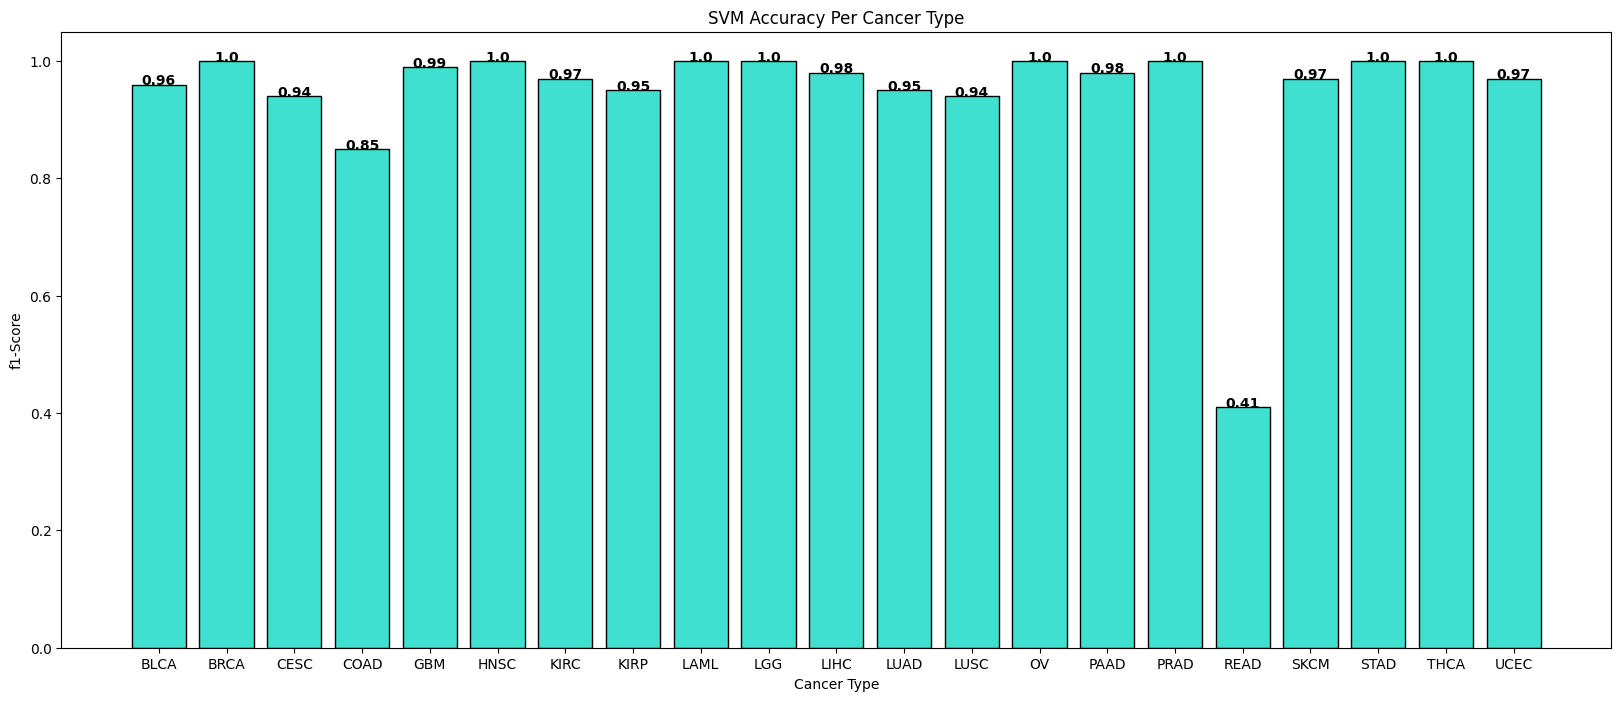

In [115]:
# Bar graph of F-1 scores by Cancer Type

plt.figure(figsize = (20,8))
cancer_type_labels = ["BLCA","BRCA","CESC","COAD","GBM","HNSC","KIRC","KIRP","LAML","LGG","LIHC","LUAD","LUSC","OV","PAAD","PRAD","READ","SKCM","STAD","THCA","UCEC"]
f1_scores = [float(i) for i in f1_list_short_formatted]
plt.bar(cancer_type_labels,f1_scores, fc = "turquoise", ec = "black")
plt.title('SVM Accuracy Per Cancer Type')
plt.xlabel('Cancer Type')
plt.ylabel('f1-Score')

for i, v in enumerate(f1_scores):
    plt.text(i, v, str(v), ha = "center", weight = "bold")

plt.show()